In [1]:
import numpy as np
import pandas as pd

In [2]:
train_data = pd.read_csv("/kaggle/input/goud-preprocessed-ML/train_preprocessed.csv")
val_data = pd.read_csv("/kaggle/input/goud-preprocessed-ML/validation_preprocessed.csv")
test_data = pd.read_csv("/kaggle/input/goud-preprocessed-ML/test_preprocessed.csv")

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
train_data.drop_duplicates(inplace=True, ignore_index=True)
val_data.drop_duplicates(inplace=True, ignore_index=True)
test_data.drop_duplicates(inplace=True, ignore_index=True)

In [5]:
train_data

,headline,categories
0,حكم ضد وزاره اعماره بتعويض قدره 13 مليار لشركه,"('جورنالات بلادي',)"
1,اعتقال مهاجم الريال رونالدو في فرنسا وها علاش صور,"('كود سبور',)"
2,الاسود المحليين يستعدون للمربع الذهبي,"('كود سبور',)"
3,تحليل هذه ابرز النقط الضائعه في قضيه القتل بمراكش والتي تجعل الجريمه غامضه لحدود الساعه,"('آراء',)"
4,جورنالات بلادي1 اموال المبادره توجه لاحداث مقاه ومحلبات ومطالب بفتح تحقيق ودوزيم مهدده بالافلاس والدوله تتدخل لانقاذها,"('جورنالات بلادي',)"
...,...,...
35939,الكبير لن يستطيع تلبيه دعوه غيريتس للمنتخب,"('آش واقع',)"
35940,سلمي رشيد ضيفه خيمه رمضان بدبي,"('ميديا وثقافة',)"
35941,الفنانه المغربيه ابتسام تسكت مطلوبه بوجده,"('الزين والحداكة',)"
35942,من بعد 15 العام تصوير تتمه فيلم ماروك لي كان نوض روينه,"('ميديا وثقافة',)"


<AxesSubplot:xlabel='categories'>

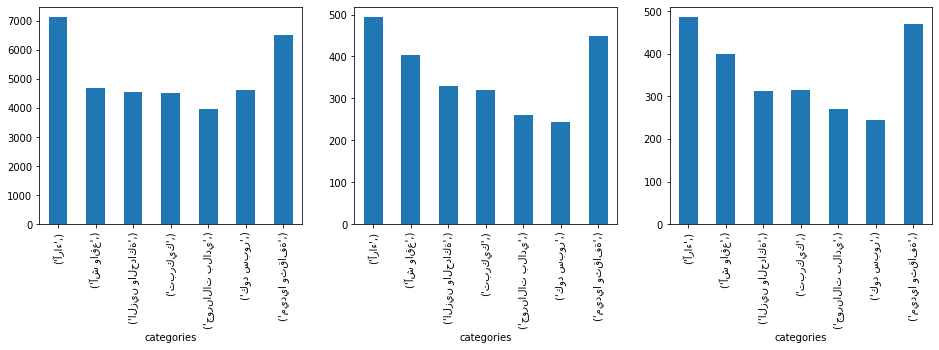

In [6]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(16,4))
train_data.groupby('categories')['headline'].count().plot.bar(ax=axs[0])
val_data.groupby('categories')['headline'].count().plot.bar(ax=axs[1])
test_data.groupby('categories')['headline'].count().plot.bar(ax=axs[2])

In [7]:
from sklearn.utils import resample

def downsample(data, column, n_samples):

  column_df = data[data["categories"] == column]

  data.drop(data[data["categories"] == column].index, inplace=True)

  column_downsampled = resample(column_df, replace=True, n_samples=n_samples, random_state=42)

  data = pd.concat([column_downsampled, data], ignore_index=True).sort_index()

  return data

In [8]:
for categ in train_data["categories"].unique():
  train_data = downsample(train_data, categ, 1000)

In [9]:
for categ in val_data["categories"].unique():
  val_data = downsample(val_data, categ, 250)

In [10]:
for categ in test_data["categories"].unique():
  test_data = downsample(test_data, categ, 250)

<AxesSubplot:xlabel='categories'>

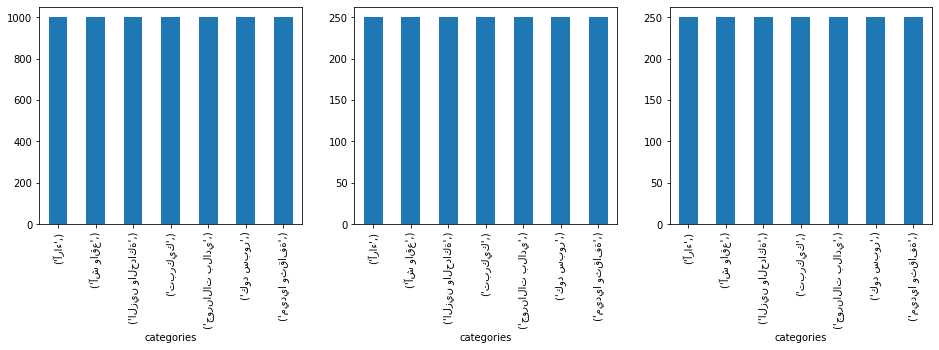

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(16,4))
train_data.groupby('categories')['headline'].count().plot.bar(ax=axs[0])
val_data.groupby('categories')['headline'].count().plot.bar(ax=axs[1])
test_data.groupby('categories')['headline'].count().plot.bar(ax=axs[2])

In [12]:
def categ2label(categ):
  labels_dict = {
      "('جورنالات بلادي',)" : 0,
      "('كود سبور',)" : 1,
      "('تبركيك',)" : 2,
      "('آراء',)" : 3,
      "('آش واقع',)" : 4,
      "('ميديا وثقافة',)" : 5,
      "('الزين والحداكة',)" : 6,
  }
  return labels_dict[categ]

In [13]:
train_data["label"] = train_data["categories"].apply(categ2label)
val_data["label"] = val_data["categories"].apply(categ2label)
test_data["label"] = test_data["categories"].apply(categ2label)

In [14]:
train_data

,headline,categories,label
0,رضوي الشربيني مولات بلوك بلوك بلوك دايره الصداع بسبب العمر ديالها الحقيقي,"('الزين والحداكة',)",6
1,بالفيديو دنيا باطما هاجمت عاود طليقه راجلها وها اش قالت ليها,"('الزين والحداكة',)",6
2,موروكو مول اللي كاري عندنا معفي من واجبات لكرا ل 3 اشهر,"('الزين والحداكة',)",6
3,الزين ولاطاي الشطاحه مايا بلوك جديد -صور,"('الزين والحداكة',)",6
4,دراسه للمدخنين ماتشربوش القهوه ولا اتاي سخون حقاش ايدير ليكم السرطان,"('الزين والحداكة',)",6
...,...,...,...
6995,حرب اردوگان علي الاكراد الاطفال المغاربه فسوريا كيهددهم الموت,"('جورنالات بلادي',)",0
6996,مجموعه هولماركوم المغربيه شرات 51 في المئه من اسهم شركه مونارش الكينيه للتامين,"('جورنالات بلادي',)",0
6997,جورنالات بلادي1 اختفاء مئات الاشجار واطنان من الحديد من شوارع الرباط في ظروف مجهوله ووثيقه تكشف استفاده احد اكبر اغنياء الصحراء بالسماره من سكن للعائدين خارج القانون,"('جورنالات بلادي',)",0
6998,30 شخص مهددون بالسجن والسبب شركات تستخلص قروضا وهميه,"('جورنالات بلادي',)",0


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(norm='l2', ngram_range=(1, 2))
features = tfidf.fit_transform(train_data['headline']).toarray()
labels = train_data["label"]
features.shape

(7000, 98163)

In [16]:
X_train = train_data["headline"]
y_train = train_data["label"]

X_val = val_data["headline"]
y_val = val_data["label"]

X_test = test_data["headline"]
y_test = test_data["label"]

In [17]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(X_train)
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
clf = MultinomialNB().fit(X_train_tfidf, y_train)

In [18]:
val_data.iloc[3]

headline      روما قانيه علي نجم مغربي واعطات فيه 5 ملايين يورو باش تجيبو عندها
categories                                                        ('كود سبور',)
label                                                                         1
Name: 3, dtype: object

In [19]:
print(clf.predict(count_vect.transform([val_data['headline'].iloc[3]])))


[2]


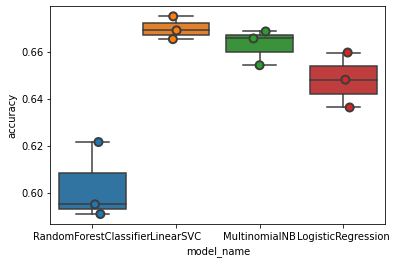

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
models = [
    RandomForestClassifier(),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 3
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])
import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [24]:
cv_df.groupby('model_name').accuracy.mean()

model_name
LinearSVC                 0.669858
LogisticRegression        0.648002
MultinomialNB             0.662858
RandomForestClassifier    0.602430
Name: accuracy, dtype: float64

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import MultinomialNB

M_NB_model = MultinomialNB()

grid_param = {
    'n_estimators': [400,500,450],
    'criterion': ['gini', 'entropy'],
    'bootstrap': [True, False],
    'max_depth': [11,12,14],
    'random_state': [0,1]
}
gd_sr = GridSearchCV(estimator=rfc_model, param_grid=grid_param, scoring='accuracy', cv=5, n_jobs=-1)
gd_sr.fit(X_with_no_outlier,y)
best_parameters = gd_sr.best_params_
print(best_parameters)
best_score = gd_sr.best_score_
print(best_score)